In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import riiideducation

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
# You can only call make_env() once, so don't lose it!
env = riiideducation.make_env()

In [3]:
# You can only iterate through a result from `env.iter_test()` once
# so be careful not to lose it once you start iterating.
iter_test = env.iter_test()

In [4]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import shap

In [5]:
#Setting global variables 
missing_column_limit = 0.6
random_seed = 0
train_size = 0.8
test_size = 1-train_size
max_cat_col_dim = 10
num_imp_str = 'median'
cat_imp_str = 'most_frequent'
oh_cosider_na = True  #do we consider NaN values while OH encoding 
xgb_threshold = 0.65

#RandomForest Citerion
rand_forest_crit = 'gini'

#training sample 
train_sample = 2000000

#XGBoost parameters
xgb_param = {
    'eta': 0.3, 
    'max_depth': 10,  
    'objective': 'binary:logistic',
    'eval_metric' :'auc'
}

In [6]:
train = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',  
                       dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 'content_type_id': 'int8',
                              'task_container_id': 'int16', 'user_answer': 'int8', 'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                             'prior_question_had_explanation': 'boolean',
                             }
                      )
train = train.set_index('row_id')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 3.1 GB


In [7]:
#lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
#lectures = lectures.set_index('lecture_id')
#lectures.info()

In [8]:
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
questions = questions.rename(columns = {'question_id':'content_id'})
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content_id      13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [9]:
def get_null_columns(data, limit):
    perc_missing = (data.count()/len(data)) 
    drop_cols_data = perc_missing[perc_missing < limit]
    drop_cols = drop_cols_data.index.tolist()
    print('---We will drop these columns---\n') 
    print(str(drop_cols_data)+'\n\n---------------------------------\n\n')

    impute_cols_data = perc_missing[(perc_missing >= limit)&(perc_missing < 1)]
    impute_cols = impute_cols_data.index.tolist()
    print('---We will impute these columns---\n') 
    print(str(impute_cols_data)+'\n\n---------------------------------\n\n')
    return(drop_cols, impute_cols)

In [10]:
def get_cat_cols(data):
    low_dim_cat_col = [col for col in data.columns 
                         if ((data[col].dtype == 'object') and 
                         (data[col].nunique() < max_cat_col_dim))] 
    high_dim_cat_col = [col for col in data.columns 
                         if ((data[col].dtype == 'object') and 
                         (data[col].nunique() >= max_cat_col_dim))] 
    print('Low dimentional Categorical colums are : ' + str(low_dim_cat_col))
    print('\n\nHigh dimentional Categorical colums are : ' + str(high_dim_cat_col))
    print('\n\n')
    return(low_dim_cat_col, high_dim_cat_col)

In [11]:
def get_train_split(X, y):
    X_train , X_valid, y_train ,y_valid = train_test_split(X, y, train_size = train_size, 
                                                           test_size = test_size, random_state = random_seed)
    return(X_train, X_valid, y_train, y_valid)

In [12]:
def get_roc_data(y_valid,pred):
    fpr, tpr, threshold = metrics.roc_curve(y_valid, pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1], '--')
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.grid()
    #plt.legend()
    return(roc_auc)

In [13]:
def get_xgb_f_imp(xgb_model):
    #Feature Importance 
    feature_names = np.array(list(xgb_model.get_score(importance_type='gain').keys()))
    f_imp_values = np.array(list(xgb_model.get_score(importance_type='gain').values()))
    sorted_index = f_imp_values.argsort()
    plt.barh(feature_names[sorted_index],f_imp_values[sorted_index])
    plt.title("Feature Importance")

In [14]:
def get_shap_values(model,X_valid):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_valid)
    shap.summary_plot(shap_values, X_valid, plot_type="bar")
    shap.summary_plot(shap_values, X_valid)

In [15]:
#Creates random forest and evaluates AUC
def get_random_forest(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators  = 100, random_state = random_seed, criterion = rand_forest_crit) 
    #original n_rstimator = 200, max_depth = 7
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    roc_auc = get_roc_data(y_valid,pred)
    return(model, roc_auc)

In [16]:
def get_xgb_overfit_check(X_train, X_valid, y_train, y_valid):
    D_train = xgb.DMatrix(X_train, label=y_train)
    D_valid = xgb.DMatrix(X_valid, label=y_valid)
    model = xgb.train(xgb_param,D_train)
    pred_valid = model.predict(D_valid)
    pred_valid = (pred_valid >= xgb_threshold )*1
    roc_auc_valid = get_roc_data(y_valid,pred_valid)
    print('AUC for test data is : '+ str(roc_auc_valid))
    
    pred_train = model.predict(D_train)
    pred_train = (pred_train >= xgb_threshold )*1
    roc_auc_train = get_roc_data(y_train,pred_train)
    print('AUC for train data is : '+ str(roc_auc_train))
    return(model)

In [17]:
def get_xgb(X_train, X_valid, y_train, y_valid):
    D_train = xgb.DMatrix(X_train, label=y_train)
    D_valid = xgb.DMatrix(X_valid)
    model = xgb.train(xgb_param,D_train)
    pred = model.predict(D_valid)
    pred = (pred >= xgb_threshold )*1
    roc_auc = get_roc_data(y_valid,pred)
    return(model,roc_auc)

In [18]:
def impute_num(data ,impute_strategy):
    num_imputer = SimpleImputer(strategy=impute_strategy)
    data_imputed = pd.DataFrame(num_imputer.fit_transform(data))
    data_imputed.columns = data.columns
    data_imputed.index = data.index
    
    return(data_imputed)

In [19]:
def impute_cat(train, test , impute_strategy):
    cat_imputer = SimpleImputer(strategy = impute_strategy) 
    train_imputed = pd.DataFrame(cat_imputer.fit_transform(train))
    train_imputed.columns = train.columns
    train_imputed.index = train.index
     
    test_imputed = pd.DataFrame(cat_imputer.transform(test))
    test_imputed.columns = test.columns
    test_imputed.index = test.index
    
    return(train_imputed, test_imputed)

In [20]:
#OneHotEncoding for both train and test data together 
def combine_one_hot(train, test):
    train['train'] = 1
    test['train'] = 0

    combined = pd.concat([housing_test_val,housing_train_val])
    combined_oh = pd.get_dummies(combined, dummy_na = oh_cosider_na)
    
    train_oh = combined_oh.loc[combined_oh.train == 1].drop(columns = 'train', axis = 1)
    test_oh = combined_oh.loc[combined_oh.train == 0].drop(columns = 'train', axis = 1)
    
    return train_oh,test_oh

In [21]:
#Process Tags
#Preprocessing questions
#Getting the tags out from the column

def process_tags(questions):
    
    tag = questions["tags"].str.split(" ", n = 6, expand = True) 
    tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
    
    #Conveting from string to numeric
    tag['tags1'] = pd.to_numeric(tag['tags1'], errors='coerce')
    tag['tags2'] = pd.to_numeric(tag['tags2'], errors='coerce')
    tag['tags3'] = pd.to_numeric(tag['tags3'], errors='coerce')
    tag['tags4'] = pd.to_numeric(tag['tags4'], errors='coerce')
    tag['tags5'] = pd.to_numeric(tag['tags5'], errors='coerce')
    tag['tags6'] = pd.to_numeric(tag['tags6'], errors='coerce')
    
    #Onehot encode tags
    #tag = tag.stack()
    #tag = pd.get_dummies(tag).groupby(level=0).sum()
    
    #imputing missing question tag values 
    tag = tag.fillna(99999)

    #Merging tags back to questions 
    questions = questions.drop(columns = 'tags', axis = 1).join(tag)
    
    return questions

In [22]:
##get_null_columns(train_X, missing_column_limit)

In [23]:
#Preprocessing
#Calculating high dimentional and low dimentional columns 
##low_dim_cat_col, high_dim_cat_col = get_cat_cols(train_X)
##cat_cols = (low_dim_cat_col + high_dim_cat_col)

In [24]:
#Sampling from train data
#Preprocessing
train_sample = train.sample(n = train_sample, random_state = random_seed).copy()
train_sample.prior_question_had_explanation = train_sample.prior_question_had_explanation*1 #converting boolian to number
train_sample = train_sample.drop(train_sample[train_sample.answered_correctly == -1].index,axis = 0)  #are lecturers 
drop_cols = ['user_answer','content_type_id']
train_X = train_sample.drop(drop_cols, axis = 1)
train_X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961082 entries, 76783108 to 1725852
Data columns (total 7 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   task_container_id               int16  
 4   answered_correctly              int8   
 5   prior_question_elapsed_time     float32
 6   prior_question_had_explanation  Int64  
dtypes: Int64(1), float32(1), int16(2), int32(1), int64(1), int8(1)
memory usage: 71.1 MB


In [25]:
questions_tag_pr = process_tags(questions)
questions_tag_pr

,content_id,bundle_id,correct_answer,part,tags1,tags2,tags3,tags4,tags5,tags6
0,0,0,0,1,51.0,131.0,162.0,38.0,99999.0,99999.0
1,1,1,1,1,131.0,36.0,81.0,99999.0,99999.0,99999.0
2,2,2,0,1,131.0,101.0,162.0,92.0,99999.0,99999.0
3,3,3,0,1,131.0,149.0,162.0,29.0,99999.0,99999.0
4,4,4,3,1,131.0,5.0,162.0,38.0,99999.0,99999.0
...,...,...,...,...,...,...,...,...,...,...
13518,13518,13518,3,5,14.0,99999.0,99999.0,99999.0,99999.0,99999.0
13519,13519,13519,3,5,8.0,99999.0,99999.0,99999.0,99999.0,99999.0
13520,13520,13520,2,5,73.0,99999.0,99999.0,99999.0,99999.0,99999.0
13521,13521,13521,0,5,125.0,99999.0,99999.0,99999.0,99999.0,99999.0


In [26]:
#Merging train data and questions 
train_questions_X = train_X.merge(questions_tag_pr,on = 'content_id', how = 'left', suffixes = ('_left', '_right'))

train_questions_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961082 entries, 0 to 1961081
Data columns (total 16 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   task_container_id               int16  
 4   answered_correctly              int8   
 5   prior_question_elapsed_time     float32
 6   prior_question_had_explanation  Int64  
 7   bundle_id                       int64  
 8   correct_answer                  int64  
 9   part                            int64  
 10  tags1                           float64
 11  tags2                           float64
 12  tags3                           float64
 13  tags4                           float64
 14  tags5                           float64
 15  tags6                           float64
dtypes: Int64(1), float32(1), float64(6), int16(2), int32(1), int64(4), int8(

In [27]:
#Imputing , Creating train, valid set 
y = train_questions_X.answered_correctly
drop_cols = ['answered_correctly']
train_questions_X = train_questions_X.drop(drop_cols, axis = 1)
train_imp = train_questions_X.copy()
#train_imp = train_imp.fillna(0)
train_imp.prior_question_elapsed_time = train_imp.prior_question_elapsed_time.fillna(0)
train_imp.prior_question_had_explanation = train_imp.prior_question_had_explanation.fillna(1)
train_imp = impute_num(train_imp ,num_imp_str)#why do I have to do this?

X_train, X_valid, y_train, y_valid = get_train_split(train_imp, y)

In [28]:
X_train_plus_y = X_train.join(y)
X_train_plus_y

,timestamp,user_id,content_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags1,tags2,tags3,tags4,tags5,tags6,answered_correctly
429242,2.961597e+10,1.930218e+09,5281.0,1110.0,17000.0,1.0,5281.0,3.0,5.0,181.0,99999.0,99999.0,99999.0,99999.0,99999.0,1
1691068,2.039788e+09,8.262440e+08,9930.0,313.0,28000.0,1.0,9930.0,3.0,5.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,1
522937,8.607704e+09,1.495276e+09,4748.0,1424.0,52000.0,1.0,4748.0,0.0,5.0,14.0,99999.0,99999.0,99999.0,99999.0,99999.0,0
173550,2.738554e+10,1.005974e+09,8022.0,2476.0,1000.0,1.0,8019.0,2.0,7.0,84.0,18.0,184.0,135.0,99999.0,99999.0,0
693062,4.554560e+09,5.195180e+08,2275.0,68.0,27666.0,1.0,2275.0,3.0,3.0,74.0,92.0,29.0,99999.0,99999.0,99999.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152315,4.118251e+10,2.147836e+07,11797.0,2646.0,31333.0,1.0,11797.0,0.0,4.0,74.0,144.0,92.0,99999.0,99999.0,99999.0,0
963395,3.433543e+09,4.060943e+08,510.0,1375.0,24000.0,1.0,510.0,1.0,2.0,148.0,32.0,38.0,29.0,99999.0,99999.0,1
117952,1.164733e+10,1.273477e+09,1102.0,2439.0,18000.0,1.0,1102.0,1.0,2.0,143.0,140.0,38.0,102.0,99999.0,99999.0,1
1484405,3.560091e+09,9.120420e+08,8509.0,2595.0,127000.0,1.0,8509.0,1.0,5.0,116.0,99999.0,99999.0,99999.0,99999.0,99999.0,1


In [29]:
#Feature engineering 
#Question accuracy
question_accuracy = pd.DataFrame(X_train_plus_y.groupby('content_id').answered_correctly.agg(['mean','count'])).reset_index()
question_accuracy = question_accuracy.rename(columns = {'mean' : 'question_hit_rate' , 'count' : 'question_shown_count'})

X_train = X_train.merge(question_accuracy,on = 'content_id',how = 'left',suffixes=('_left', '_right'))
X_valid = X_valid.merge(question_accuracy,on = 'content_id',how = 'left',suffixes=('_left', '_right'))

print(X_valid.loc[X_valid.question_shown_count.isnull()].content_id.nunique())
question_accuracy

60


,content_id,question_hit_rate,question_shown_count
0,0.0,0.897959,98
1,1.0,0.885246,122
2,2.0,0.555233,688
3,3.0,0.787958,382
4,4.0,0.594041,537
...,...,...,...
13322,13518.0,0.800000,10
13323,13519.0,0.500000,10
13324,13520.0,0.565217,23
13325,13521.0,0.642857,14


In [30]:
#Feature engineering 
#User accuracy

#user_accuracy = X_train_plus_y.groupby('user_id').answered_correctly.count().reset_index()
#user_accuracy = user_accuracy.rename(columns = {'answered_correctly' : 'user_questions_asked'})

#user_accuracy = X_train_plus_y.groupby('user_id').answered_correctly.agg(['mean','count']).reset_index()
#user_accuracy = user_accuracy.rename(columns = {'count' : 'user_questions_asked','mean':'user_accuracy'})

#user_accuracy_50perc_data = user_accuracy.sample(frac = 0.1, random_state = random_seed).copy()
#X_train = X_train.merge(user_accuracy_50perc_data,on = 'user_id',how = 'left',suffixes=('_left', '_right'))
#X_valid = X_valid.merge(user_accuracy_50perc_data,on = 'user_id',how = 'left',suffixes=('_left', '_right'))
#X_valid.info()
#user_accuracy

In [31]:
#Feature engineering 
#tag1 accuracy 
#tags1_accuracy = pd.DataFrame(X_train_plus_y.groupby('tags1').answered_correctly.agg(['mean','count'])).reset_index()
#tags1_accuracy = tags1_accuracy.rename(columns = {'mean' : 'tags1_hit_rate' , 'count' : 'tags1_shown_count'})

#X_train = X_train.merge(tags1_accuracy,on = 'tags1',how = 'left',suffixes=('_left', '_right'))
#X_valid = X_valid.merge(tags1_accuracy,on = 'tags1',how = 'left',suffixes=('_left', '_right'))

#print(X_valid.loc[X_valid.tags1_hit_rate.isnull()].tags1.nunique())

#tags1_accuracy

In [32]:
#Feature engineering 
#task_container_id accuracy 
#task_container_accuracy = pd.DataFrame(X_train_plus_y.groupby('task_container_id').answered_correctly.agg(['mean'])).reset_index()
#task_container_accuracy = task_container_accuracy.rename(columns = {'mean' : 'task_container_hit_rate'})

#X_train = X_train.merge(task_container_accuracy,on = 'task_container_id',how = 'left',suffixes=('_left', '_right'))
#X_valid = X_valid.merge(task_container_accuracy,on = 'task_container_id',how = 'left',suffixes=('_left', '_right'))

#print(X_valid.loc[X_valid.task_container_hit_rate.isnull()].task_container_id.nunique())
#task_container_accuracy

In [33]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392217 entries, 0 to 392216
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   timestamp                       392217 non-null  float64
 1   user_id                         392217 non-null  float64
 2   content_id                      392217 non-null  float64
 3   task_container_id               392217 non-null  float64
 4   prior_question_elapsed_time     392217 non-null  float64
 5   prior_question_had_explanation  392217 non-null  float64
 6   bundle_id                       392217 non-null  float64
 7   correct_answer                  392217 non-null  float64
 8   part                            392217 non-null  float64
 9   tags1                           392217 non-null  float64
 10  tags2                           392217 non-null  float64
 11  tags3                           392217 non-null  float64
 12  tags4           

In [34]:
#Checking for the best xgb_threshold value
#for i in np.arange(0.6,0.7,0.01):
#    xgb_threshold = i
#    model_xgb, error = get_xgb(X_train, X_valid, y_train, y_valid)
#    print('AUC for '+str(i)+' is '+ str(error))
#0.65 had the best AUC

AUC for test data is : 0.657181896784011
AUC for train data is : 0.6711513241940401


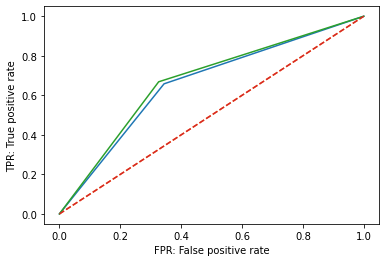

In [35]:
#Model
#XGBoost


#checking with new model
xgb_model = get_xgb_overfit_check(X_train, X_valid, y_train, y_valid)


AUC is : 0.7188611838128982


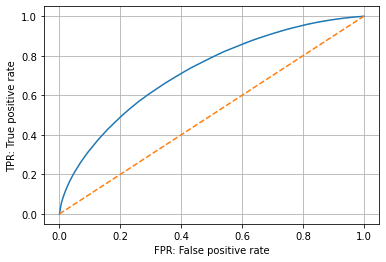

In [36]:
#Showig how AUC is different if we dont call (pred >= xgb_threshold)

D_test = xgb.DMatrix(X_valid)
pred = xgb_model.predict(D_test)
roc_auc = get_roc_data(y_valid,pred)
print('AUC is : '+ str(roc_auc))
#AUC is : 0.648535236410687 #hit_rate + high_accuracy_question + low_accuracy_question + with leakage
#AUC is : 0.648535236410687 #hit_rate + with leakage
#AUC is : 0.6497669237360347 #question hit_rate + question_count + no leakage
#AUC is : 0.6515780212479896 #Fill by na(0 &1 ) + question hit_rate + question_count + no leakage
#AUC is : 0.6488785264625494 #Fill by na(0 &1 ) + question hit_rate + question_count + no leakage + user answer count
#AUC is : 0.707353504193343 #Fill by na(0 &1 ) + question hit_rate + question_count + no leakage + Use merge for questions
#AUC is : 0.7077340398970969 #Fill by na(0 &1 ) + question hit_rate + question_count + no leakage + Use merge for questions + dont impute tags
#AUC is : 0.707353504193343 #Fill by na(0 &1 ) + question hit_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill -999999
#AUC is : 0.7078187632238334 #Fill by na(0 &1 ) + question hi t_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill 999999
#AUC is : 0.7074413605069291 #Fill by na(0 &1 ) + question hi t_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill 999999 + tags1 hit rate + tags 1count 
#AUC is : 0.6981012344897761 #Fill by na(0 &1 ) + question hi t_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill 999999 + task container hit rate + task container 1count
#AUC is : 0.6980741768469736 #Fill by na(0 &1 ) + question hi t_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill 999999 + task container hit rate
#AUC is : 0.7127142878709594 #Fill by na(0 &1 ) + question hi t_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill 999999 + training sample 1,000,000
#AUC is : 0.7245025584453728 #Fill by na(0 &1 ) + question hi t_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill 999999 + training sample 10,000,000
#AUC is : 0.7236795322410227 #Fill by na(0 &1 ) + question hi t_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill 999999 + training sample 5,000,000
#AUC is : 0.7188611838128982 #Fill by na(0 &1 ) + question hi t_rate + question_count + no leakage + Use merge for questions + dont impute tags + tags fill 999999 + training sample 2,000,000

In [37]:
#Analyzing XGB Model
#Feature importance
#plt.figure(figsize = (20,20))
#get_xgb_f_imp(xgb_model)

In [38]:
#SHAP values
#get_shap_values(xgb_model,X_valid)

In [39]:
#Tuning XGB
#D_train = xgb.DMatrix(X_train, y_train)
#D_valid = xgb.DMatrix(X_valid, y_valid)

#watchlist = [(D_train, 'train'), (D_valid, 'valid')]

#xgb_model = xgb.train(xgb_param, D_train, 2000, watchlist, early_stopping_rounds = 100, verbose_eval = 10)


In [40]:
#Analyzing XGB Model
#Feature importance
#plt.figure(figsize = (20,20))
#get_xgb_f_imp(model)

In [41]:
#SHAP values
#get_shap_values(model,X_valid)

In [42]:
#Check prediction

for (test_df, sample_prediction_df) in iter_test:
    
    test_df = test_df.set_index('row_id')
    test_copy = test_df.copy()
    
    test_copy = test_copy.drop(test_copy[test_copy.content_type_id == 1].index,axis = 0)
    drop_cols = ['prior_group_answers_correct','prior_group_responses','content_type_id']
    test_copy = test_copy.drop(columns = drop_cols,axis = 1)
    
    test_copy.prior_question_had_explanation = test_copy.prior_question_had_explanation*1 #converting boolian to number

    
    
    #test_questions_X = test_copy.join(questions, on = 'content_id', how = 'left', lsuffix = ' ')
    test_questions_X = test_copy.merge(questions_tag_pr,on = 'content_id', how = 'left', suffixes = ('_left', '_right'))
    #drop_cols = ['content_id']
    
    #test_questions_X = test_questions_X.drop(drop_cols, axis = 1)
    #test_questions_X =  test_questions_X.rename(columns = {'content_id ':'content_id'})
    
    test_copy_imp = test_questions_X.copy()
    test_copy_imp.prior_question_elapsed_time = test_copy_imp.prior_question_elapsed_time.fillna(0)
    test_copy_imp.prior_question_had_explanation = test_copy_imp.prior_question_had_explanation.fillna(1)


    test_copy_imp = impute_num(test_copy_imp ,num_imp_str)

    test_copy_imp = test_copy_imp.merge(question_accuracy,on = 'content_id',how = 'left',suffixes=('_left', '_right'))
    
    
    
    D_test = xgb.DMatrix(test_copy_imp)
    pred = xgb_model.predict(D_test)
    #pred = (pred >= xgb_threshold )*1
    
    df = pd.DataFrame({'row_id': test_copy.index, 'answered_correctly': pred})
    df = df.set_index('row_id')
    test_df = test_df.join(df)
    test_df.answered_correctly.fillna(-1, inplace = True)
    
    
    test_df = test_df.reset_index()
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

In [43]:
#To Do
#Use part 
#One hot encoding of Part --> Didnt give good result
#Add tags 
#process them and one hot encoding --> Didnt give good result 
#Add lectures --> Not needed
#Change order , join with questions after imputing 
#Feature engineering 
    #Users correct rate --> Didnt give good result  --> Data leakage
    #Questions correct rate 
    #Part accuracy --> Didnt give good result
#--------------------
#Feature engineering 
    #Other features?

#Move out from Pandas 
#Use full data
#Try Light GBM
#Check if I reuse any data provided by the loop